# Results 2b: Similarity Analysis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from tqdm import tqdm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

In [2]:
## Load reject data.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Section 1: Proportion of Participants Flagged 

#### 1.1 Accuracy

```python
from scipy.stats import binom_test
binom_test(38, n=90, p=0.33, alternative='greater')
```

In [3]:
from statsmodels.stats.proportion import proportions_ztest

## Perform 2-sample proportion test on platform.
zval, pval = proportions_ztest([18, 8], [186, 200])
print('z = %0.3f, p = %0.3f' %(zval, pval))

## Tally failing participants.
metrics.groupby('platform').accuracy.agg(
    mean = lambda x: (x < 0.38).mean(),
    sum = lambda x: (x <0.38).sum(),
    count = lambda x: x.size
).round(2)

z = 2.224, p = 0.026


,mean,sum,count
platform,,,
mturk,0.10,18.0,186.0
prolific,0.04,8.0,200.0


#### 2.2 Infrequency Items

In [4]:
from statsmodels.stats.proportion import proportions_ztest

## Perform 2-sample proportion test on platform.
zval, pval = proportions_ztest([50, 35], [186, 200])
print('z = %0.3f, p = %0.3f' %(zval, pval))

## Tally failing participants.
metrics.groupby('platform').infreq.agg(
    mean = lambda x: (x > 0).mean(),
    sum = lambda x: (x > 0).sum(),
    count = lambda x: x.size
).round(2)

z = 2.223, p = 0.026


,mean,sum,count
platform,,,
mturk,0.27,50,186
prolific,0.18,35,200


## Section 2: Metric Correspondence

In [5]:
## Define variables of interest.
cols = ['infreq','isd','reliability','mahalanobis','survey_rt','variability','accuracy','wsls','task_rt']

## Precompute lower triangular indices.
ix = np.tril_indices(len(cols), k=-1)

## Precompute space for results.
tril = np.zeros((ix[0].size, 3))
fwer = np.zeros((ix[0].size, 3))

#### 3.1 Monotonic Dependence (Unthresholded)

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,0] = metrics[cols].corr(method='spearman').values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = metrics[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = permuted.corr(method='spearman').values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,0] = ((np.abs(tril[:,0]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / n_iter

100%|██████████| 5000/5000 [00:27<00:00, 179.36it/s]


#### 3.2 Rejection Similarity (Thresohold = 25%) 

In [7]:
from scipy.spatial.distance import dice

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define quantile.
q = 0.25

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Threshold parameters. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Copy reject DataFrame.
thresh = metrics[cols].copy()

## Threshold variables.
thresh['infreq'] = np.where( thresh['infreq'] > 0, 1, 0 )
thresh['isd'] = np.where( thresh['isd'] > thresh['isd'].quantile(1-q), 1, 0 )
thresh['reliability'] = np.where( thresh['reliability'] < thresh['reliability'].quantile(q), 1, 0 )
thresh['mahalanobis'] = np.where( thresh['mahalanobis'] > thresh['mahalanobis'].quantile(1-q), 1, 0 )
thresh['survey_rt'] = np.where( thresh['survey_rt'] < thresh['survey_rt'].quantile(q), 1, 0 )
thresh['variability'] = np.where( thresh['variability'] > thresh['variability'].quantile(1-q), 1, 0 )
thresh['accuracy'] = np.where( thresh['accuracy'] < thresh['accuracy'].quantile(q), 1, 0 )
thresh['wsls'] = np.where( thresh['wsls'] < thresh['wsls'].quantile(q), 1, 0 )
thresh['task_rt'] = np.where( thresh['task_rt'] > thresh['task_rt'].quantile(1-q), 1, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,1] = 1 - thresh[cols].corr(method=dice).values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = thresh[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = 1 - permuted.corr(method=dice).values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,1] = ((np.abs(tril[:,1]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / n_iter

100%|██████████| 5000/5000 [00:39<00:00, 125.88it/s]


#### 3.3 Rejection Similarity (Thresohold = 10%) 

In [8]:
from scipy.spatial.distance import dice

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define quantile.
q = 0.10

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Threshold parameters. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Copy reject DataFrame.
thresh = metrics[cols].copy()

## Threshold variables.
thresh['infreq'] = np.where( thresh['infreq'] > 0, 1, 0 )
thresh['isd'] = np.where( thresh['isd'] > thresh['isd'].quantile(1-q), 1, 0 )
thresh['reliability'] = np.where( thresh['reliability'] < thresh['reliability'].quantile(q), 1, 0 )
thresh['mahalanobis'] = np.where( thresh['mahalanobis'] > thresh['mahalanobis'].quantile(1-q), 1, 0 )
thresh['survey_rt'] = np.where( thresh['survey_rt'] < thresh['survey_rt'].quantile(q), 1, 0 )
thresh['variability'] = np.where( thresh['variability'] > thresh['variability'].quantile(1-q), 1, 0 )
thresh['accuracy'] = np.where( thresh['accuracy'] < thresh['accuracy'].quantile(q), 1, 0 )
thresh['wsls'] = np.where( thresh['wsls'] < thresh['wsls'].quantile(q), 1, 0 )
thresh['task_rt'] = np.where( thresh['task_rt'] > thresh['task_rt'].quantile(1-q), 1, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,2] = 1 - thresh[cols].corr(method=dice).values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = thresh[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = 1 - permuted.corr(method=dice).values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,2] = ((np.abs(tril[:,2]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / (n_iter + 1)

100%|██████████| 5000/5000 [00:39<00:00, 127.72it/s]


## Section 3: Plotting

https://stats.stackexchange.com/questions/9918/how-to-compute-correlation-between-within-groups-of-variables

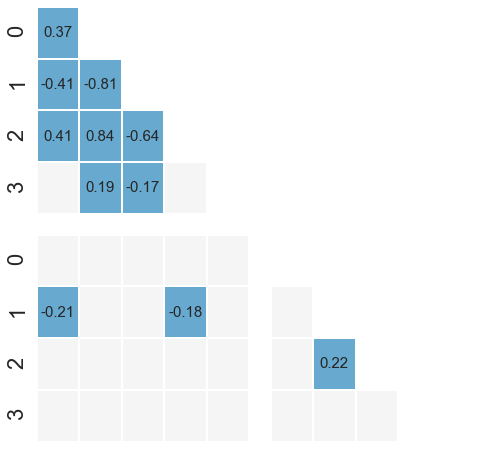

In [11]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

## Initialize canvas.
fig = plt.figure(figsize=(8,8))
cmap = ListedColormap(['#de425b','0.95','#67a9cf'])
                     
titles = ['Spearman Correlation', 'Dice Similarity (Top 25%)', 'Dice Similarity (Top 10%)']
labels = ['INF','ISD','REL','MAH','READ','VAR','ACC','WSLS','RT']
    
## Initialize grid.
gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.1, hspace=0.1)

## Initialize correlation matrix.
corr = np.zeros((8,10))
corr[np.tril_indices_from(corr, k=0)] = np.where(fwer[:,0] < 0.05, tril[:,0], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Self-report correlations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize axis.
ax = plt.subplot(gs[0,0])

## Plot correlations.
arr = corr[:4,:5]
sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1, 
            xticklabels=[], mask=np.triu(np.ones_like(arr), k=1), ax=ax)

## Add annotations.
for i, j in np.array(np.where(arr)).T:
    ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15)

# ## Add borders.
# ax.hlines([-0.1,4.1], -0.1, 4.1, linestyle='--', color='0.5')
# ax.vlines([-0.1,4.1], -0.1, 4.1, linestyle='--', color='0.5')

# ## Add details.
# ax.set(xlim=(-0.2,4.2), ylim=(-0.2,4.2))
# ax.invert_yaxis()
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Self-report correlations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize axis.
ax = plt.subplot(gs[1,0])

## Plot correlations.
arr = corr[4:,:5]
sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1, 
            xticklabels=[], ax=ax)

## Add annotations.
for i, j in np.array(np.where(arr)).T:
    ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15)

# ## Add borders.
# ax.hlines([-0.1,4.1], -0.1, 5.1, linestyle='--', color='0.5')
# ax.vlines([-0.1,5.1], -0.1, 4.1, linestyle='--', color='0.5')

# ## Add details.
# ax.set(xlim=(-0.2,5.2), ylim=(-0.2,4.2))
# ax.invert_yaxis()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Self-report correlations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize axis.
ax = plt.subplot(gs[1,1])

## Plot correlations.
arr = corr[4:,5:]
sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1,
            xticklabels=[], yticklabels=[], mask=np.triu(np.ones_like(arr), k=0), ax=ax)

## Add annotations.
for i, j in np.array(np.where(arr)).T:
    ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15)

# ## Add borders.
# ax.hlines([-0.1,4.1], -0.1, 5.1, linestyle='--', color='0.5')
# ax.vlines([-0.1,5.1], -0.1, 4.1, linestyle='--', color='0.5')

# ## Add details.
# ax.set(xlim=(-0.2,5.2), ylim=(-0.2,4.2))
# ax.invert_yaxis()